# Machine Learning Utils - Classification example: Titanic dataset (Kaggle)

### 0 - Setup

In [1]:
from ml_utils import *

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
dtf = pd.read_csv('data_titanic.csv')
dtf.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


len dtf: 891
PassengerId --> Nas: 0 (0.0%)
    # possible pk
Survived --> Nas: 0 (0.0%)
Pclass --> Nas: 0 (0.0%)
Name --> Nas: 0 (0.0%)
    # possible pk
Sex --> Nas: 0 (0.0%)
Age --> Nas: 177 (19.900000000000002%)
SibSp --> Nas: 0 (0.0%)
Parch --> Nas: 0 (0.0%)
Ticket --> Nas: 0 (0.0%)
Fare --> Nas: 0 (0.0%)
Cabin --> Nas: 687 (77.10000000000001%)
Embarked --> Nas: 2 (0.2%)


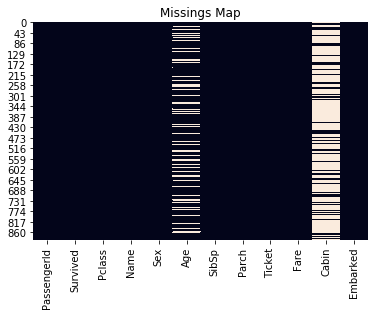

In [3]:
check_Nas(dtf, plot="map")

### 1 - Data Analysis

###### Group variables by info
- pk: PassengerId, Name
- y: Survived
- who: Sex, Age, Embarked (which port C=Cherbourg, Q=Queenstown, S=Southampton)
- wealth: Pclass, Ticket, Fare
- where: Cabin
- how many: SibSp (with siblings/spouse), Parch (with parent/children)

In [4]:
features = []

###### Target Variable

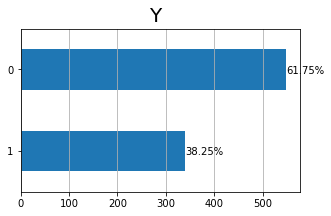

In [58]:
dtf = dtf.rename(columns={"Survived":"Y"})

freqdist_plot(dtf, "Y", figsize=(5,3))

In [6]:
# Population mean: 38% of the passengers survived

###### 1.1 - Who? Sex, Age, Embarked

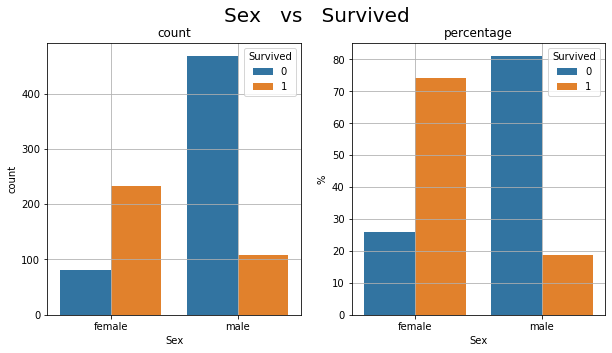

In [7]:
# Sex
bivariate_plot(dtf, x="Sex", y="Survived", figsize=(10,5))

In [8]:
## Sex is Predictive: the surviving rate of females is higher.
features.append("Sex")

C:\profili\u382270\Downloads\MyStuff\py\DataScience_Utils\machine_learning\ml_utils.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_NA[na_x] = dtf[na_x].apply(lambda x: "Value" if not pd.isna(x) else "NA")


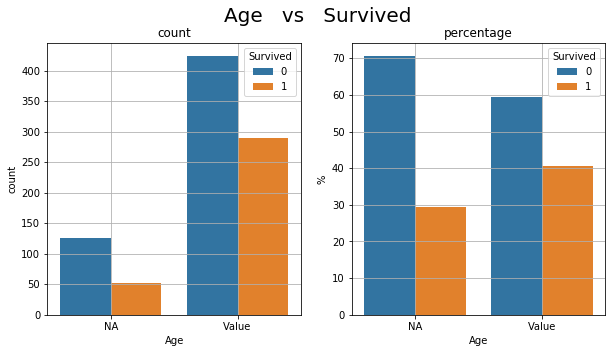

In [9]:
# Age
nan_analysis(dtf, na_x="Age", y="Survived", max_cat=20, figsize=(10,5))

In [10]:
dtf["Age"].mean()

29.69911764705882

In [11]:
dtf["Age"] = dtf["Age"].fillna( dtf["Age"].mean() )

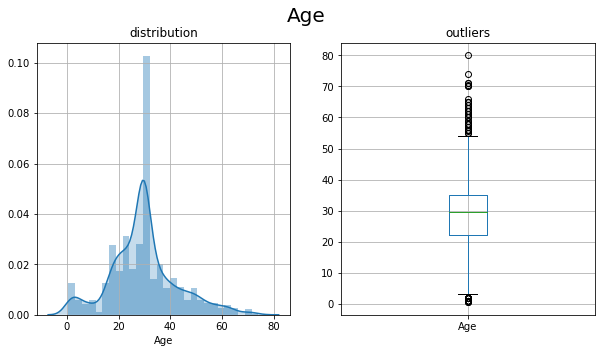

In [12]:
freqdist_plot(dtf, "Age", figsize=(10,5))

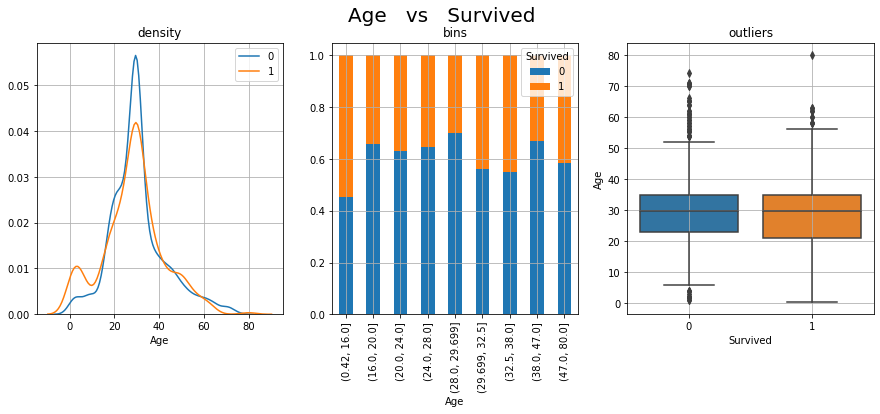

In [13]:
bivariate_plot(dtf, x="Age", y="Survived", figsize=(15,5))

In [14]:
## Age is Predictive: the Surviving rate is higher for younger passengers, there is a spike in the left tail of Y=1 
## distribution and the first bin of Age (0-16) contains the highest percentage of survived people.
features.append("Age")

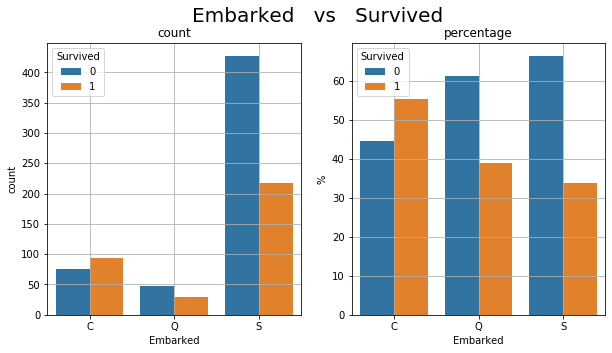

In [15]:
# Embarked
bivariate_plot(dtf, x="Embarked", y="Survived", figsize=(10,5))

In [16]:
coeff, p = test_corr(dtf, x="Embarked", y="Survived")

Cramer Correlation: 0.166 Significant (p-value: 0.0)


In [17]:
## Embarked is Predictive: People from port C tend to survive better (that can be because they stayed in a fortunate area
## of the ship or just because they're smarter). Since there aren't many observations, I tested the significance 
## of the correlation (Cramer cat vs cat), it passed.
features.append("Embarked")

###### 1.2 - Wealth? Pclass, Ticket, Fare

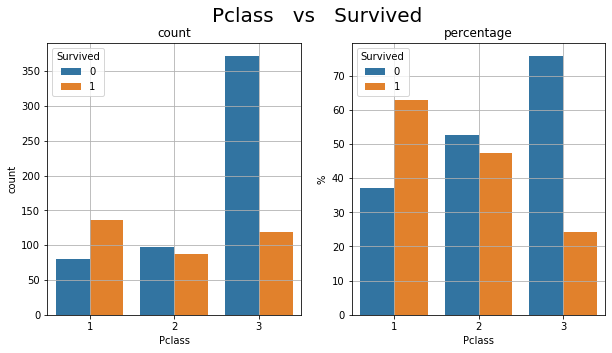

In [18]:
# Pclass
bivariate_plot(dtf, x="Pclass", y="Survived", figsize=(10,5))

In [19]:
## Pclass is Predctive: the richer the higher the probability of surviving.
features.append("Pclass")

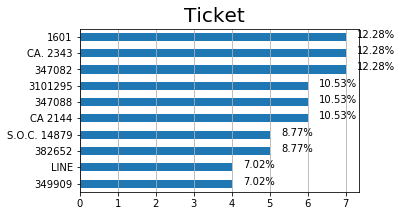

In [20]:
# Ticket
freqdist_plot(dtf, "Ticket", top=10, figsize=(5,3))

In [21]:
## Useless

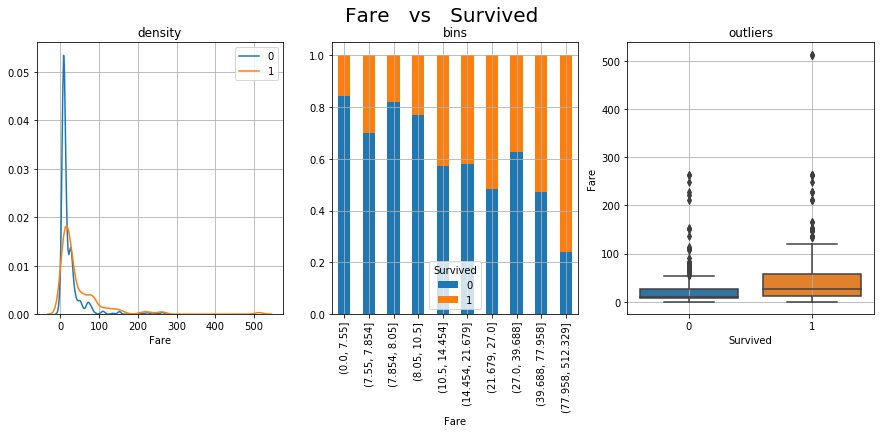

In [22]:
# Fare
bivariate_plot(dtf, x="Fare", y="Survived", figsize=(15,5))

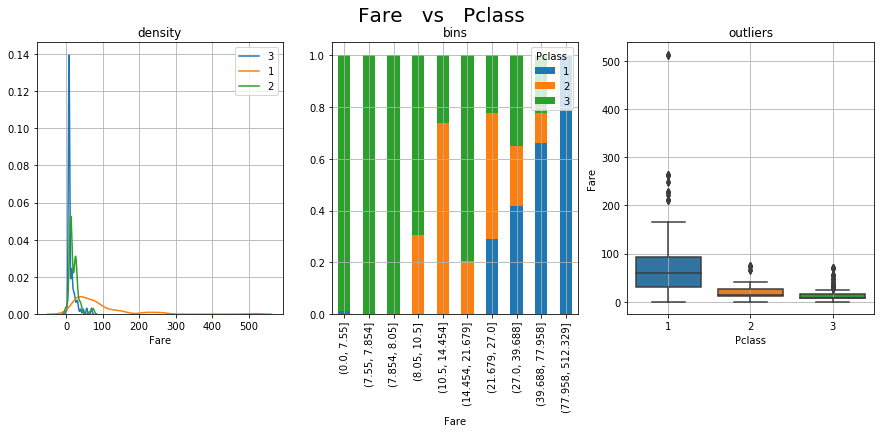

In [23]:
## Fare is Predictive: it gives the same info of Pclass
bivariate_plot(dtf, x="Fare", y="Pclass", figsize=(15,5))

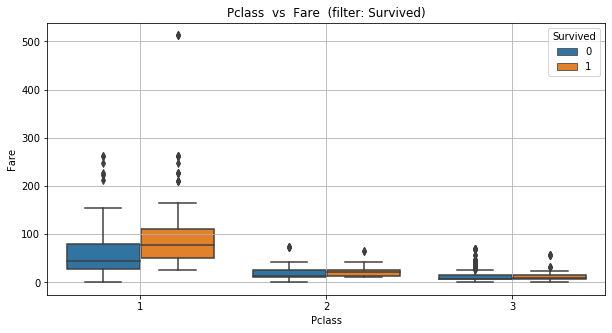

In [24]:
cross_distributions(dtf, x1="Pclass", x2="Fare", y="Survived", figsize=(10,5))

In [25]:
## Looks there is more information in the first class: who paid higher price survived better.
## I will keep it for now and exclude one of the two in the Features Selection section.
features.append("Fare")

###### 1.3 - Where? Cabin

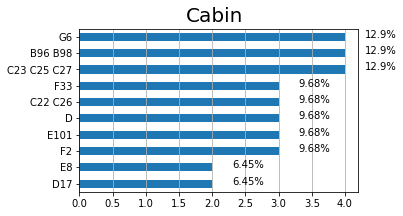

In [26]:
# Cabin
freqdist_plot(dtf, "Cabin", top=10, figsize=(5,3))

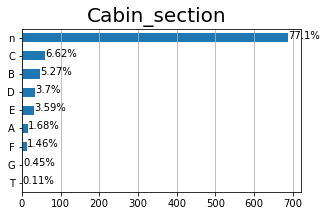

In [27]:
## Useless like this, let's see if the variable can be clustered using the first letter of the cabin:
dtf["Cabin_section"] = dtf["Cabin"].apply(lambda x: str(x)[0])
freqdist_plot(dtf, "Cabin_section", top=10, figsize=(5,3))

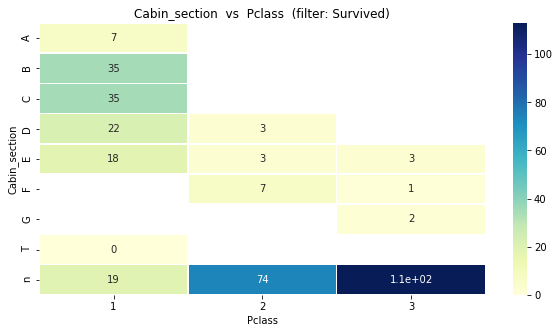

In [28]:
cross_distributions(dtf, x1="Cabin_section", x2="Pclass", y="Survived", figsize=(10,5))

###### 1.4 - How many? SibSp, Parch

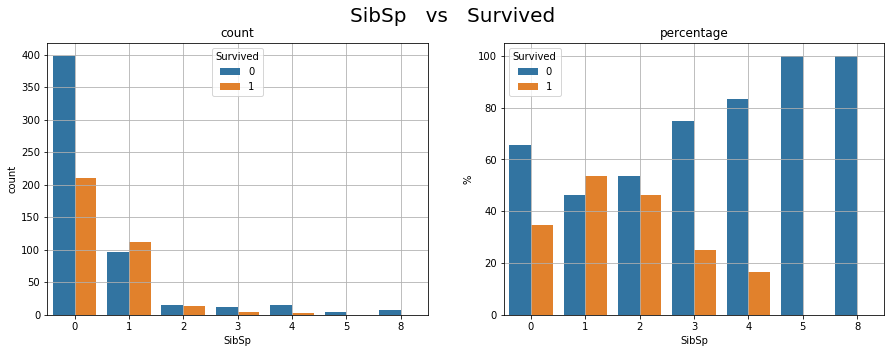

In [29]:
bivariate_plot(dtf, x="SibSp", y="Survived", figsize=(15,5))

In [30]:
features.append("SibSp")

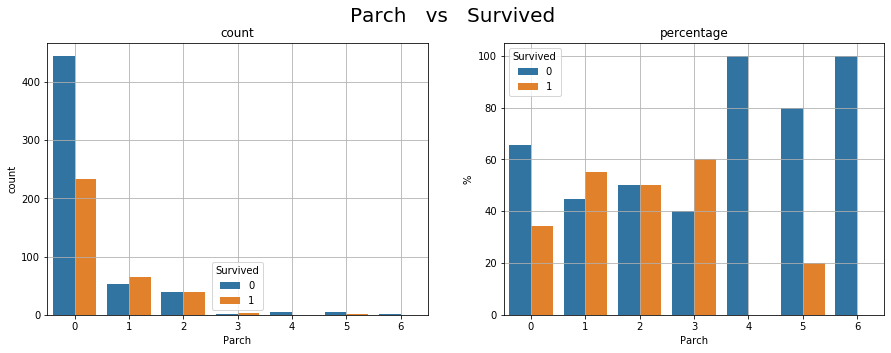

In [31]:
bivariate_plot(dtf, x="Parch", y="Survived", figsize=(15,5))

In [32]:
features.append("Parch")

###### Summary

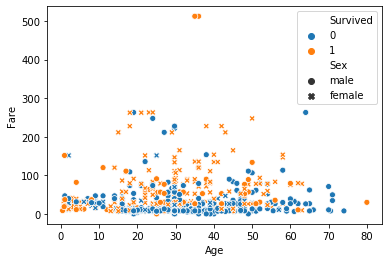

In [33]:
sns.scatterplot(data=dtf, x="Age", y="Fare", hue="Survived", style="Sex")

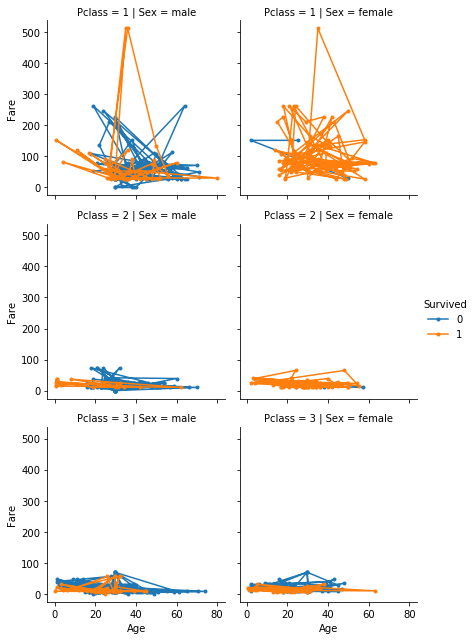

In [34]:
g = sns.FacetGrid(dtf, col="Sex",  row="Pclass", hue="Survived")
g.map(plt.plot, "Age", "Fare", marker=".").add_legend()

In [35]:
dtf = dtf[["PassengerId"]+features+["Survived"]]
dtf.head()

,PassengerId,Sex,Age,Embarked,Pclass,Fare,SibSp,Parch,Survived
0,1,male,22.0,S,3,7.2500,1,0,0
1,2,female,38.0,C,1,71.2833,1,0,1
2,3,female,26.0,S,3,7.9250,0,0,1
3,4,female,35.0,S,1,53.1000,1,0,1
4,5,male,35.0,S,3,8.0500,0,0,0


### 2 - Preprocessing

In [36]:
check = data_preprocessing(dtf, pk="PassengerId", y="Survived", task="classification",
                           processNas=None, processCategorical=None, split=None, scale=None)

--- check missing ---
--- check categorical data ---
--- split train/test ---
   OK: skipped this step
--- scaling ---
   OK: skipped this step


###### NAs

In [37]:
dtf = dtf[dtf["Embarked"].notnull()]
print(dtf.shape)

(889, 9)


###### Categorical

In [38]:
dtf = add_dummies(dtf, x="Embarked", dropx=True, dummy_na=False)

In [39]:
dtf = add_dummies(dtf, x="Sex", dropx=True, dummy_na=False)

###### Partitioning + Scaling

In [41]:
dic_data = data_preprocessing(dtf, pk="PassengerId", y="Survived", task="classification",
                              processNas=None, processCategorical=None, split=0.3, scale="standard")

X_names = dic_data["X_names"]
X_train, X_test = dic_data["X"]
Y_train, Y_test = dic_data["Y"]
scaler, _ = dic_data["scaler"]

--- check missing ---
   OK: No missing
--- check categorical data ---
   OK: No categorical
--- split train/test ---
X_train shape: (622, 8)  | X_test shape: (267, 8)
1s in y_train: 0.38  | 1s in y_test: 0.4
8 features: ['Age', 'Pclass', 'Fare', 'SibSp', 'Parch', 'Embarked_Q', 'Embarked_S', 'Sex_male']
--- scaling ---
   OK: scaled all features


### 3 - Baseline

###### Train

In [42]:
baseline = ensemble.GradientBoostingClassifier()

In [43]:
dic_model = fit_classif_model(baseline, X_train, Y_train, X_test, Y_test, Y_threshold=0.5)

predicted_prob, predicted = dic_model["predicted_prob"], dic_model["predicted"]

Accuracy (overall correct predictions): 0.783
Auc: 0.84
Recall (ability to get all 1s): 0.613
Precision (success rate when predicting a 1): 0.793
Detail:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       161
           1       0.79      0.61      0.69       106

    accuracy                           0.78       267
   macro avg       0.79      0.75      0.76       267
weighted avg       0.78      0.78      0.78       267



###### Evaluate

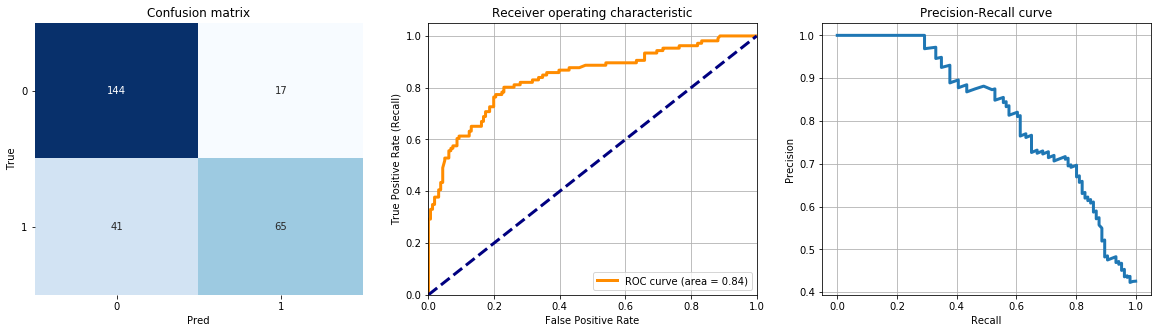

In [44]:
evaluate_model(Y_test, predicted, predicted_prob, figsize=(20,5))

### 4 - Model Desing & Testing

###### Features Selection

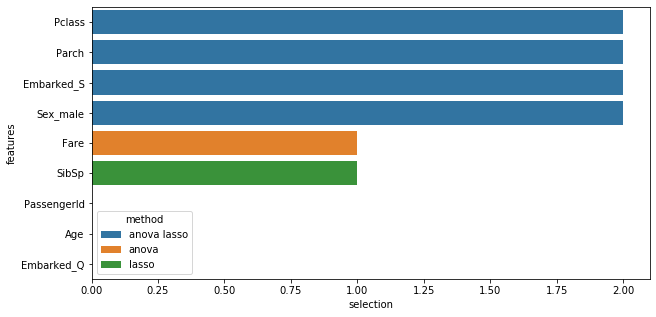

In [45]:
dic_feat_sel = features_selection(dtf, y="Survived", top=5, figsize=(10,5))

In [46]:
dic_feat_sel

{'anova': Index(['Pclass', 'Fare', 'Parch', 'Embarked_S', 'Sex_male'], dtype='object'),
 'lasso': Index(['Pclass', 'SibSp', 'Parch', 'Embarked_S', 'Sex_male'], dtype='object'),
 'join': ['Embarked_S', 'Parch', 'Sex_male', 'Pclass']}

In [47]:
dtf = dtf[["PassengerId"]+dic_feat_sel["join"]+["Survived"]]

In [48]:
dic_data = data_preprocessing(dtf, pk="PassengerId", y="Survived", task="classification",
                              processNas=None, processCategorical=None, split=0.3, scale="standard")

X_names = dic_data["X_names"]
X_train, X_test = dic_data["X"]
Y_train, Y_test = dic_data["Y"]
scaler, _ = dic_data["scaler"]

--- check missing ---
   OK: No missing
--- check categorical data ---
   OK: No categorical
--- split train/test ---
X_train shape: (622, 4)  | X_test shape: (267, 4)
1s in y_train: 0.38  | 1s in y_test: 0.4
4 features: ['Embarked_S', 'Parch', 'Sex_male', 'Pclass']
--- scaling ---
   OK: scaled all features


###### Train

In [50]:
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      #weighting factor for the corrections by new trees when added to the model
             'n_estimators':[100,250,500,750,1000,1250,1500,1750],  #captures the number of trees that we add to the model
             'max_depth':[2,3,4,5,6,7],                             #maximum depth of the tree
             'min_samples_split':[2,4,6,8,10,20,40,60,100],         #sets the minimum number of samples to split
             'min_samples_leaf':[1,3,5,7,9],                        #the minimum number of samples to form a leaf
             'max_features':[2,3,4,5,6,7],                          #square root of features is usually a good starting point
             'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}            #the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.

RANDOMSEARCH


C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStuff\anaconda2\envs\env1\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
C:\profili\u382270\Downloads\MyStu

Best Model parameters: {'subsample': 1, 'n_estimators': 750, 'min_samples_split': 20, 'min_samples_leaf': 7, 'max_features': 4, 'max_depth': 5, 'learning_rate': 0.001}
Best Model mean accuracy: 0.8183096774193549

K-FOLD VALIDATION
accuracy mean: from 0.7975678443420379  ---->  0.8183819764464927


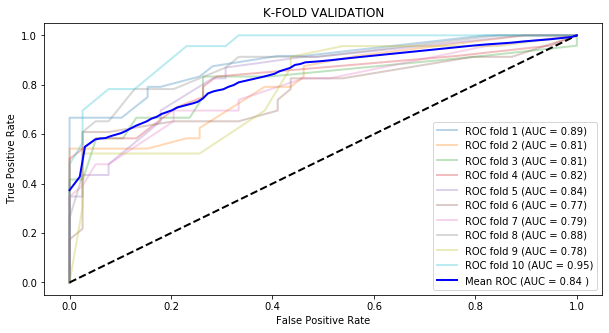

In [52]:
model = model_tuning(X_train, Y_train, baseline, param_dic, scoring="accuracy", 
                     searchtype="RandomSearch", n_iter=1000, cv=10, figsize=(10,5))

In [53]:
dic_model = fit_classif_model(model, X_train, Y_train, X_test, Y_test, Y_threshold=0.5)

model, predicted_prob, predicted = dic_model["model"], dic_model["predicted_prob"], dic_model["predicted"]

Accuracy (overall correct predictions): 0.787
Auc: 0.847
Recall (ability to get all 1s): 0.509
Precision (success rate when predicting a 1): 0.915
Detail:
              precision    recall  f1-score   support

           0       0.75      0.97      0.85       161
           1       0.92      0.51      0.65       106

    accuracy                           0.79       267
   macro avg       0.83      0.74      0.75       267
weighted avg       0.82      0.79      0.77       267



###### Evaluate

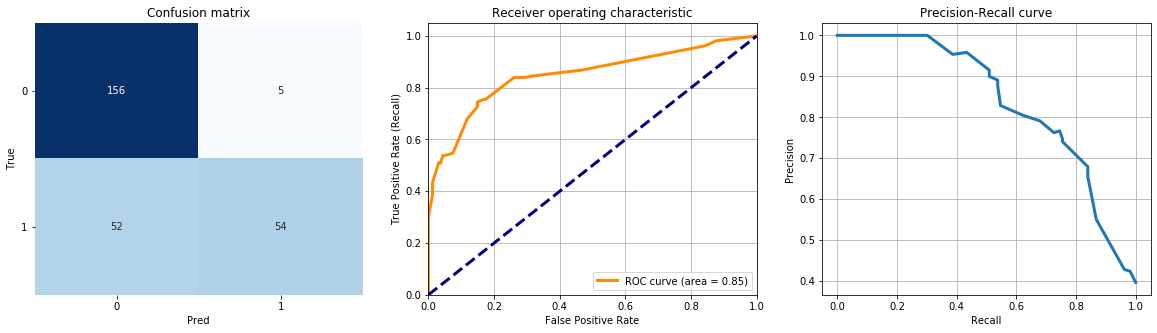

In [54]:
evaluate_model(Y_test, predicted, predicted_prob, figsize=(20,5))